[<img src='https://github.com/jeshraghian/snntorch/blob/master/docs/_static/img/snntorch_alpha_w.png?raw=true' width="300">](https://github.com/jeshraghian/snntorch/)

# Predicting PV panel power output from weather data with SNNs
### From Forecast to Field: Leveraging Spiking Neural Networks for Solar Energy Prediction in Agriculture

<a href="https://colab.research.google.com/github/jeshraghian/snntorch/blob/master/examples/quickstart.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

[<img src='https://github.com/jeshraghian/snntorch/blob/master/docs/_static/img/GitHub-Mark-Light-120px-plus.png?raw=true' width="28">](https://github.com/jeshraghian/snntorch/) [<img src='https://github.com/jeshraghian/snntorch/blob/master/docs/_static/img/GitHub_Logo_White.png?raw=true' width="80">](https://github.com/jeshraghian/snntorch/)

For a comprehensive overview on how SNNs work, and what is going on under the hood, [then you might be interested in the snnTorch tutorial series available here.](https://snntorch.readthedocs.io/en/latest/tutorials/index.html)
The snnTorch tutorial series is based on the following paper. If you find these resources or code useful in your work, please consider citing the following source:

> <cite> [Jason K. Eshraghian, Max Ward, Emre Neftci, Xinxin Wang, Gregor Lenz, Girish Dwivedi, Mohammed Bennamoun, Doo Seok Jeong, and Wei D. Lu. "Training Spiking Neural Networks Using Lessons From Deep Learning". Proceedings of the IEEE, 111(9) September 2023.](https://ieeexplore.ieee.org/abstract/document/10242251) </cite>

In [1]:
!pip install -r requirements.txt

  Obtaining dependency information for snntorch from https://files.pythonhosted.org/packages/51/d5/9800809f6e87e4f4b3a4429178f9e6241b94557358738e0932e835fad9e8/snntorch-0.9.1-py2.py3-none-any.whl.metadata
  Obtaining dependency information for nrel-pysam from https://files.pythonhosted.org/packages/55/b6/ac37afd124eb05d2d306bbc30390bb8ff47ece2116ba5a9108d26ecfd0dc/NREL_PySAM-5.1.0-cp311-cp311-manylinux2014_x86_64.whl.metadata
  Obtaining dependency information for pandas from https://files.pythonhosted.org/packages/fc/a5/4d82be566f069d7a9a702dcdf6f9106df0e0b042e738043c0cc7ddd7e3f6/pandas-2.2.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
  Obtaining dependency information for scikit-learn from https://files.pythonhosted.org/packages/46/c0/63d3a8da39a2ee051df229111aa93f6dca2b56f8080abd34993938166455/scikit_learn-1.5.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
  Obtaining dependency information for matplotlib from https://files.pythonhoste

In [2]:
import os
from tqdm import tqdm
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

import snntorch as snn
import snntorch.functional as SF
from snntorch import surrogate
from snntorch import utils

In [9]:
#Uncomment if you run on Google Drive.
#from google.colab import drive
#drive.mount('/content/drive')

In [10]:
# use GPU if available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

## 1. Weather dataset

We are using weather data obtained from the [NREL System Advisor Model (SAM)](https://sam.nrel.gov/) application. It outputs `.csv` data aggregated by year for the specified location. We have chosen weather data at a location near [Des Moines, Iowa](https://www.google.com/maps/place/42%C2%B001'16.5%22N+93%C2%B046'25.4%22W/@42.0212449,-93.7762968,17z/data=!3m1!4b1!4m4!3m3!8m2!3d42.0212449!4d-93.7737219?entry=ttu). This weather data is used in conjunection with the `nrel-pysam` python module to model the power produced by a theoretical solar array. This data is used in-place of real power output data. The `nrel-pysam` module does not have the capability to estimate power into the future, which is the goal of this tutorial. Below covers the dataloading and preprocessing before being fed into the Neural Nets.

### 1.1 Dataloading
Define parameters for dataloading. Columns for `Month` and `Hour` are included to account for different seasons in the year and daylight hours respectively.

In [11]:
# path to raw weather data
DATA_PATH = "./data/weather_rawdata/"
# Near Des Moines, Iowa
LOCATION_PREFIX = "42.02124491636418_-93.77372190333062_42.0212_-93.7741_psm3_60_"

INPUT_COLUMNS = ["Month", "Hour", "DNI", "DHI", "GHI", "Dew Point", "Temperature", "Pressure",
                 "Relative Humidity", "Wind Direction", "Wind Speed", "Surface Albedo",]
OUTPUT_COLUMNS = ["Power Next"]

# number of training data points
N_TRAIN_HOURS = 365 * 24 * 18
# number of validation data points
N_VAL_HOURS = 365 * 24 * 2

# list of all filepaths
filepaths = []
for year in range(2000, 2021):
  path = os.path.join(DATA_PATH, f"{LOCATION_PREFIX}{str(year)}.csv")
  filepaths.append(path)

Load weather dataset into a `pandas.DataFrame`.

In [12]:
weather_data = []

for path in filepaths:
  weather_data_year = pd.read_csv(path, skiprows=2)
  weather_data.append(weather_data_year)

weather_data = pd.concat(weather_data)
weather_data = weather_data.reset_index(drop=True)

# Add timestamp
weather_data["Timestamp"] = pd.to_datetime(weather_data[["Year", "Month", "Day", "Hour", "Minute"]])
weather_data = weather_data.drop(["Year", "Day", "Minute"], axis=1)
# reorder columns
weather_data = weather_data[["Timestamp", "Month", "Hour", "DNI", "DHI", "GHI", "Dew Point", "Temperature", "Pressure",
                             "Relative Humidity", "Wind Direction", "Wind Speed", "Surface Albedo",]]

Model power output of PV panels at current timestep of weather data. After modeling, shift the power data back one timestep so that the power data corresponds to the next days power output.

In [13]:
import PySAM.Pvwattsv8 as pv
import PySAM.Grid as gr
import PySAM.Utilityrate5 as ur
import PySAM.Singleowner as so

output_power = []

for path in tqdm(filepaths):
  # create an instance of the Pvwattsv8 module with defaults from the PVWatts - Single Owner configuration
  system_model = pv.default('PVWattsSingleOwner')
  # create instances of the other modules with shared data from the PVwattsv8 module
  grid_model = gr.from_existing(system_model, 'PVWattsSingleOwner')
  utilityrate_model = ur.from_existing(system_model, 'PVWattsSingleOwner')
  financial_model = so.from_existing(system_model, 'PVWattsSingleOwner')
  system_model.SolarResource.solar_resource_file = path
  # run the modules in the correct order
  system_model.execute()
  grid_model.execute()
  utilityrate_model.execute()
  financial_model.execute()
  # display results
  #print( 'Annual AC Output in Year 1 = {:,.3f} kWh'.format( system_model.Outputs.ac_annual ) )
  #print( 'Net Present Value = ${:,.2f}'.format(financial_model.Outputs.project_return_aftertax_npv) )
  dc = system_model.Outputs.dc
  #ac = system_model.Outputs.ac

  output_power.append(dc)

# concat individual lists
output_power = np.concatenate(output_power)
# create dataframe
output_power = pd.DataFrame(output_power, columns=["Power"])
# shift to align current weather data to power of the next day
output_power["Power Next"] = output_power["Power"].shift(-1)

100%|█| 21/21 [00:02<00:00,  7.53it/s


Examples tables and plots showing the first two months of data. Notice the power output is extremely high, on the order of 100s to 1000s of kWs. When training, the scale of these values posed challenges during training.

,Month,Hour,DNI,DHI,GHI,Dew Point,Temperature,Pressure,Relative Humidity,Wind Direction,Wind Speed,Surface Albedo,Power,Power Next
Timestamp,,,,,,,,,,,,,,
2000-01-01 00:30:00,1,0,0,0,0,-2.0,-1.0,970,89.84,244.9,3.1,0.154,0.000000e+00,0.000000e+00
2000-01-01 01:30:00,1,1,0,0,0,-2.0,-2.0,970,88.66,255.3,2.4,0.154,0.000000e+00,0.000000e+00
2000-01-01 02:30:00,1,2,0,0,0,-2.0,-2.0,970,88.81,266.6,2.0,0.154,0.000000e+00,0.000000e+00
2000-01-01 03:30:00,1,3,0,0,0,-2.0,-2.0,970,89.68,284.7,1.5,0.154,0.000000e+00,0.000000e+00
2000-01-01 04:30:00,1,4,0,0,0,-2.0,-1.0,970,90.24,310.4,1.1,0.154,0.000000e+00,0.000000e+00
2000-01-01 05:30:00,1,5,0,0,0,-2.0,-1.0,970,90.42,350.9,1.1,0.154,0.000000e+00,0.000000e+00
2000-01-01 06:30:00,1,6,0,0,0,-2.0,-1.0,970,90.01,23.7,1.2,0.154,0.000000e+00,0.000000e+00
2000-01-01 07:30:00,1,7,0,0,0,-2.0,0.0,970,83.34,43.3,1.9,0.154,0.000000e+00,1.545578e+06
2000-01-01 08:30:00,1,8,0,25,25,-2.0,0.0,970,83.74,54.5,2.7,0.154,1.545578e+06,1.816017e+07


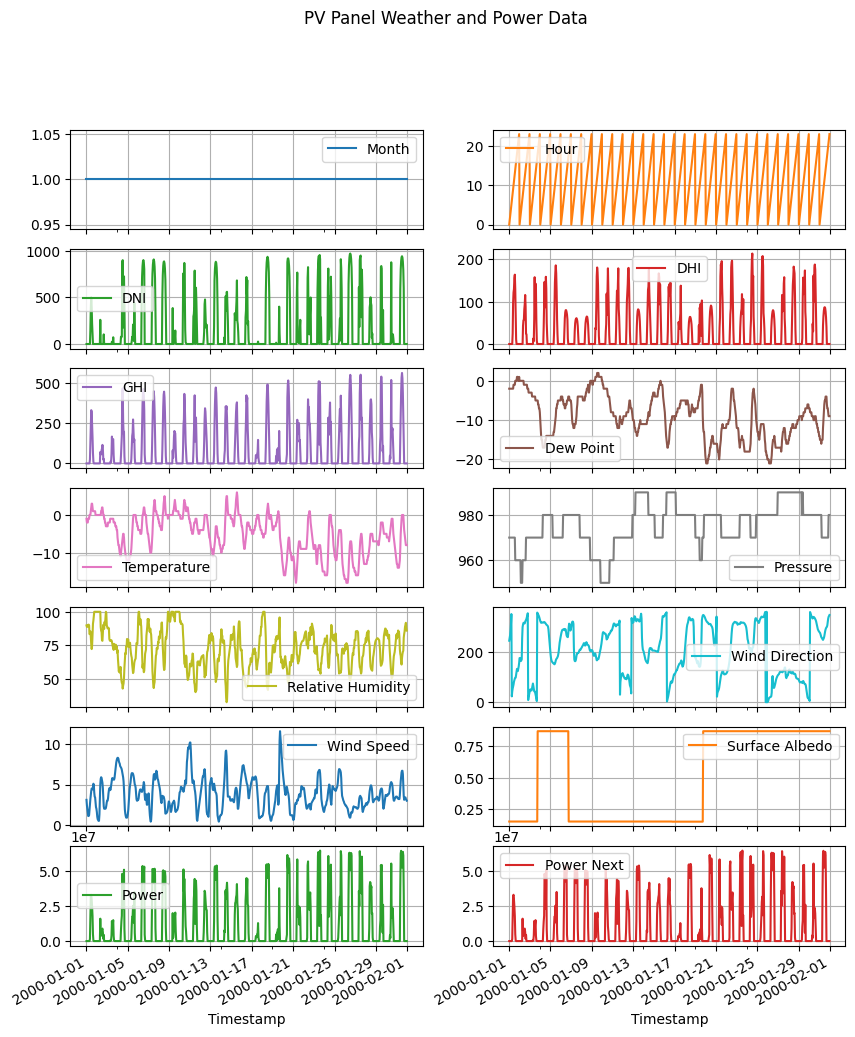

In [14]:
combined_data = pd.concat([weather_data, output_power], axis=1)
combined_data = combined_data.dropna()
combined_data = combined_data.set_index("Timestamp")
display(combined_data.head(10))

first_year = combined_data[combined_data.index < pd.to_datetime("2000-02-01")]
first_year.plot(
  subplots=True,
  title="PV Panel Weather and Power Data",
  grid=True,
  layout=(7,2),
  figsize=(10,12)
  )
plt.show()

Convert data into train, validation, and test sets and load them onto the GPU. The inputs **AND** outputs are scaled using `scipy.preprocessing.StandardScalar` to create a dataset with `mean = 0` and `std = 1`. Scaling the input feature to the same distribution assigns them equal weights so that features with high magnitudes don't overpower other features. The outputs were scaled as well to work better during NN training.

In [15]:
BATCH_SIZE = 72

# convert to numpy arrays
input_series = combined_data[INPUT_COLUMNS].to_numpy()
output_series = combined_data[OUTPUT_COLUMNS].to_numpy()

input_scaler = StandardScaler()
output_scaler = StandardScaler()

input_series = input_scaler.fit_transform(input_series)
output_series = output_scaler.fit_transform(output_series)

input_series = torch.as_tensor(input_series).to(torch.float32).to(device)
output_series = torch.as_tensor(output_series).to(torch.float32).to(device)

# training data
train_inputs = input_series[:N_TRAIN_HOURS, :]
train_outputs = output_series[:N_TRAIN_HOURS]

# create dataloaders
train_dataset = TensorDataset(train_inputs, train_outputs)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE)

# validation data
val_inputs = input_series[N_TRAIN_HOURS:N_TRAIN_HOURS+N_VAL_HOURS, :]
val_outputs = output_series[N_TRAIN_HOURS:N_TRAIN_HOURS+N_VAL_HOURS]

val_dataset = TensorDataset(val_inputs, val_outputs)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

# test data
test_inputs = input_series[N_TRAIN_HOURS+N_VAL_HOURS:, :]
test_outputs = output_series[N_TRAIN_HOURS+N_VAL_HOURS:]

test_dataset = TensorDataset(test_inputs, test_outputs)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

## 2. LSTM Model

We first train a simple LSTM network with a single layer of `size = 50` to use as a comparison to the SNN. We use *mean absolute error* as our loss function. On the first attempt the NN was trained using the true output data with really high magnitude resulting in high loss values on the order of `1e6` and slow convergence. As a result we set `LR = 1000` which gave slightly better results. To improve the model, we added output scaling to normalize the data to reasonable values with the results being shown below. We think the better performance was due to being more compatable with the internal parameters within `pytorch`.

In [16]:
#
# Create network
#

class LSTM(nn.Module):
  def __init__(self, input_size):
    """LSTM NN Constructor"""
    super(LSTM, self).__init__()

    self.lstm = nn.LSTM(input_size, 50)
    self.fc = nn.Linear(50, 1)

  def forward(self, x):
    """Forward pass of LSTM network"""

    lstm_out, _ = self.lstm(x)
    output = self.fc(lstm_out)
    return output

# load onto GPU
lstm_net = LSTM(len(train_inputs[0])).to(device)


#
# Train Network
#

# default learning rate from tf.keras.optimizers.Adam
LEARNING_RATE = 0.0001

EPOCHS = 100

# Adam optimizers
optimizer = optim.Adam(lstm_net.parameters(), lr=LEARNING_RATE)
# Mean absolute error
loss_fn = nn.L1Loss()


loss_train_hist = []
loss_val_hist = []


# training loop
for epoch in tqdm(range(EPOCHS)):
  loss_train_epoch = []

  lstm_net.train()
  for inputs, outputs in train_loader:
    # forward pass
    predictions = lstm_net(inputs)
    # calculate loss from membrane potential at last timestep
    loss_val = loss_fn(predictions, outputs)
    # zero out gradients
    optimizer.zero_grad()
    # calculate gradients
    loss_val.backward()
    # update weights
    optimizer.step()

    # store loss
    loss_train_epoch.append(loss_val.item())

  # calculate average loss p/epoch
  avg_loss_epoch_train = sum(loss_train_epoch) / len(loss_train_epoch)
  loss_train_hist.append(avg_loss_epoch_train)


  loss_val_epoch = []

  lstm_net.eval()
  for inputs, outputs in val_loader:
    predictions = lstm_net(inputs)
    loss_val = loss_fn(predictions, outputs)
    loss_val_epoch.append(loss_val.item())

  avg_loss_epoch_val = sum(loss_val_epoch) / len(loss_val_epoch)
  loss_val_hist.append(avg_loss_epoch_val)

  print(f"Epoch: {epoch+1}/{EPOCHS}, Train Loss: {avg_loss_epoch_train}, Val Loss: {avg_loss_epoch_val}")

  1%| | 1/100 [00:04<07:40,  4.66s/it

Epoch: 1/100, Train Loss: 0.3612639455184272, Val Loss: 0.21518025388483142


  2%| | 2/100 [00:09<07:27,  4.57s/it

Epoch: 2/100, Train Loss: 0.20524377805355204, Val Loss: 0.17936898752680566


  3%| | 3/100 [00:13<07:22,  4.56s/it

Epoch: 3/100, Train Loss: 0.1808554713448433, Val Loss: 0.1607477973658042


  4%| | 4/100 [00:18<07:15,  4.53s/it

Epoch: 4/100, Train Loss: 0.16644408094556365, Val Loss: 0.15147292394129958


  5%| | 5/100 [00:22<07:13,  4.57s/it

Epoch: 5/100, Train Loss: 0.15943540325345787, Val Loss: 0.1474302583450421


  6%| | 6/100 [00:27<07:11,  4.59s/it

Epoch: 6/100, Train Loss: 0.15554831741233122, Val Loss: 0.1436233368442684


  7%| | 7/100 [00:32<07:12,  4.65s/it

Epoch: 7/100, Train Loss: 0.15289404305148888, Val Loss: 0.14054957536033919


  8%| | 8/100 [00:36<07:05,  4.62s/it

Epoch: 8/100, Train Loss: 0.15088822761354925, Val Loss: 0.13862724782379923


  9%| | 9/100 [00:41<07:05,  4.67s/it

Epoch: 9/100, Train Loss: 0.14916988837460404, Val Loss: 0.13720702641017612


 10%| | 10/100 [00:46<07:00,  4.67s/i

Epoch: 10/100, Train Loss: 0.1478560549534483, Val Loss: 0.1361589281224325


 11%| | 11/100 [00:50<06:53,  4.65s/i

Epoch: 11/100, Train Loss: 0.14670361154563896, Val Loss: 0.13505550405224326


 12%| | 12/100 [00:55<06:49,  4.65s/i

Epoch: 12/100, Train Loss: 0.14569514290382873, Val Loss: 0.13446462939142204


 13%|▏| 13/100 [01:00<06:43,  4.64s/i

Epoch: 13/100, Train Loss: 0.1447745583381623, Val Loss: 0.1340252841349508


 14%|▏| 14/100 [01:04<06:40,  4.66s/i

Epoch: 14/100, Train Loss: 0.1440209558250629, Val Loss: 0.13343393294232303


 15%|▏| 15/100 [01:09<06:32,  4.61s/i

Epoch: 15/100, Train Loss: 0.1433647591892851, Val Loss: 0.13293349213104266


 16%|▏| 16/100 [01:13<06:29,  4.63s/i

Epoch: 16/100, Train Loss: 0.14279723670588781, Val Loss: 0.13293367944902085


 17%|▏| 17/100 [01:18<06:27,  4.67s/i

Epoch: 17/100, Train Loss: 0.1422418254117171, Val Loss: 0.13292519858137505


 18%|▏| 18/100 [01:23<06:19,  4.63s/i

Epoch: 18/100, Train Loss: 0.14175312522730735, Val Loss: 0.133451579673002


 19%|▏| 19/100 [01:27<06:14,  4.62s/i

Epoch: 19/100, Train Loss: 0.14127003180296863, Val Loss: 0.13307834743354163


 20%|▏| 20/100 [01:32<06:09,  4.62s/i

Epoch: 20/100, Train Loss: 0.14091760000919915, Val Loss: 0.1327335993438715


 21%|▏| 21/100 [01:37<06:07,  4.66s/i

Epoch: 21/100, Train Loss: 0.14053588282555068, Val Loss: 0.1321239912516025


 22%|▏| 22/100 [01:41<06:01,  4.64s/i

Epoch: 22/100, Train Loss: 0.14022278579879024, Val Loss: 0.13201349312592237


 23%|▏| 23/100 [01:46<05:55,  4.61s/i

Epoch: 23/100, Train Loss: 0.139909059612174, Val Loss: 0.13209472318775342


 24%|▏| 24/100 [01:51<05:51,  4.62s/i

Epoch: 24/100, Train Loss: 0.13960668795814388, Val Loss: 0.13194534545917003


 25%|▎| 25/100 [01:55<05:48,  4.65s/i

Epoch: 25/100, Train Loss: 0.13931283586101445, Val Loss: 0.13194032401212905


 26%|▎| 26/100 [02:00<05:44,  4.65s/i

Epoch: 26/100, Train Loss: 0.13908006891727312, Val Loss: 0.13175673625569362


 27%|▎| 27/100 [02:05<05:39,  4.65s/i

Epoch: 27/100, Train Loss: 0.1388260125977808, Val Loss: 0.131738712812667


 28%|▎| 28/100 [02:09<05:33,  4.63s/i

Epoch: 28/100, Train Loss: 0.13856154171469276, Val Loss: 0.13155574754613344


 29%|▎| 29/100 [02:14<05:27,  4.62s/i

Epoch: 29/100, Train Loss: 0.1383503773917346, Val Loss: 0.1319919287333967


 30%|▎| 30/100 [02:18<05:22,  4.61s/i

Epoch: 30/100, Train Loss: 0.13813422041515647, Val Loss: 0.13198166322268423


 31%|▎| 31/100 [02:23<05:18,  4.62s/i

Epoch: 31/100, Train Loss: 0.13792131524703138, Val Loss: 0.132234152482792


 32%|▎| 32/100 [02:28<05:16,  4.66s/i

Epoch: 32/100, Train Loss: 0.13773479274554884, Val Loss: 0.13102826175325719


 33%|▎| 33/100 [02:32<05:12,  4.67s/i

Epoch: 33/100, Train Loss: 0.1375076164410675, Val Loss: 0.13107667005330811


 34%|▎| 34/100 [02:37<05:06,  4.64s/i

Epoch: 34/100, Train Loss: 0.13733317631734832, Val Loss: 0.13115521248613224


 35%|▎| 35/100 [02:42<05:02,  4.66s/i

Epoch: 35/100, Train Loss: 0.13715552034868633, Val Loss: 0.1313971747476302


 36%|▎| 36/100 [02:46<04:58,  4.67s/i

Epoch: 36/100, Train Loss: 0.13702865437812864, Val Loss: 0.13073706837584737


 37%|▎| 37/100 [02:51<04:54,  4.68s/i

Epoch: 37/100, Train Loss: 0.13684451826699248, Val Loss: 0.13132325146103002


 38%|▍| 38/100 [02:56<04:48,  4.66s/i

Epoch: 38/100, Train Loss: 0.13672407312514304, Val Loss: 0.13133855438867553


 39%|▍| 39/100 [03:00<04:43,  4.65s/i

Epoch: 39/100, Train Loss: 0.13649991239382797, Val Loss: 0.1306113792415403


 40%|▍| 40/100 [03:05<04:35,  4.60s/i

Epoch: 40/100, Train Loss: 0.13636141976928465, Val Loss: 0.1304922346331057


 41%|▍| 41/100 [03:09<04:31,  4.60s/i

Epoch: 41/100, Train Loss: 0.13623425227390032, Val Loss: 0.13137570583856986


 42%|▍| 42/100 [03:14<04:26,  4.60s/i

Epoch: 42/100, Train Loss: 0.13608261008606587, Val Loss: 0.1312608732765571


 43%|▍| 43/100 [03:19<04:21,  4.58s/i

Epoch: 43/100, Train Loss: 0.13592681627822656, Val Loss: 0.13094499360647846


 44%|▍| 44/100 [03:23<04:16,  4.59s/i

Epoch: 44/100, Train Loss: 0.13580637147233365, Val Loss: 0.13066225382117708


 45%|▍| 45/100 [03:28<04:11,  4.57s/i

Epoch: 45/100, Train Loss: 0.13571543305363828, Val Loss: 0.13103689969379884


 46%|▍| 46/100 [03:32<04:08,  4.61s/i

Epoch: 46/100, Train Loss: 0.13558815439235947, Val Loss: 0.1303236315362766


 47%|▍| 47/100 [03:37<04:06,  4.65s/i

Epoch: 47/100, Train Loss: 0.13546033167667246, Val Loss: 0.13071742321013427


 48%|▍| 48/100 [03:42<04:02,  4.66s/i

Epoch: 48/100, Train Loss: 0.13531469735678403, Val Loss: 0.13104392727073588


 49%|▍| 49/100 [03:46<03:56,  4.63s/i

Epoch: 49/100, Train Loss: 0.1352214972280204, Val Loss: 0.12942882157007202


 50%|▌| 50/100 [03:51<03:52,  4.64s/i

Epoch: 50/100, Train Loss: 0.1351129943113689, Val Loss: 0.13002010597465713


 51%|▌| 51/100 [03:56<03:45,  4.60s/i

Epoch: 51/100, Train Loss: 0.1349914508552788, Val Loss: 0.13032375232576102


 52%|▌| 52/100 [04:00<03:40,  4.60s/i

Epoch: 52/100, Train Loss: 0.13491242401744133, Val Loss: 0.13030265498387275


 53%|▌| 53/100 [04:05<03:37,  4.63s/i

Epoch: 53/100, Train Loss: 0.13481600956532033, Val Loss: 0.13002648842750025


 54%|▌| 54/100 [04:09<03:33,  4.64s/i

Epoch: 54/100, Train Loss: 0.13469967656858164, Val Loss: 0.12998913172021753


 55%|▌| 55/100 [04:14<03:29,  4.67s/i

Epoch: 55/100, Train Loss: 0.13461812123333075, Val Loss: 0.1288886533469939


 56%|▌| 56/100 [04:19<03:26,  4.69s/i

Epoch: 56/100, Train Loss: 0.13449316511789686, Val Loss: 0.12903191324811977


 57%|▌| 57/100 [04:23<03:17,  4.60s/i

Epoch: 57/100, Train Loss: 0.13443533253545562, Val Loss: 0.1285765037077983


 58%|▌| 58/100 [04:28<03:14,  4.64s/i

Epoch: 58/100, Train Loss: 0.13432937941458672, Val Loss: 0.12888981788953552


 59%|▌| 59/100 [04:33<03:09,  4.62s/i

Epoch: 59/100, Train Loss: 0.1342630068673731, Val Loss: 0.12871415845927645


 60%|▌| 60/100 [04:37<03:02,  4.56s/i

Epoch: 60/100, Train Loss: 0.13413869938876938, Val Loss: 0.1283829179287079


 61%|▌| 61/100 [04:42<02:58,  4.59s/i

Epoch: 61/100, Train Loss: 0.13406519771013495, Val Loss: 0.12828673036066723


 62%|▌| 62/100 [04:46<02:54,  4.59s/i

Epoch: 62/100, Train Loss: 0.13401127693043452, Val Loss: 0.12840329981638027


 63%|▋| 63/100 [04:51<02:50,  4.60s/i

Epoch: 63/100, Train Loss: 0.13392784889217585, Val Loss: 0.12856959572947416


 64%|▋| 64/100 [04:56<02:45,  4.60s/i

Epoch: 64/100, Train Loss: 0.13379285949958514, Val Loss: 0.12820953166600865


 65%|▋| 65/100 [05:00<02:40,  4.60s/i

Epoch: 65/100, Train Loss: 0.1337779151858362, Val Loss: 0.12822121497029898


 66%|▋| 66/100 [05:05<02:35,  4.58s/i

Epoch: 66/100, Train Loss: 0.13365407365812287, Val Loss: 0.1281777059689897


 67%|▋| 67/100 [05:09<02:30,  4.57s/i

Epoch: 67/100, Train Loss: 0.13359705204373762, Val Loss: 0.1283745704921054


 68%|▋| 68/100 [05:14<02:26,  4.59s/i

Epoch: 68/100, Train Loss: 0.13353346607107755, Val Loss: 0.12803795393251005


 69%|▋| 69/100 [05:18<02:22,  4.59s/i

Epoch: 69/100, Train Loss: 0.13349636717907845, Val Loss: 0.12819630903054458


 70%|▋| 70/100 [05:23<02:17,  4.58s/i

Epoch: 70/100, Train Loss: 0.1334260012903442, Val Loss: 0.12824996933341026


 71%|▋| 71/100 [05:28<02:13,  4.61s/i

Epoch: 71/100, Train Loss: 0.13333617906388082, Val Loss: 0.12821079731812


 72%|▋| 72/100 [05:32<02:09,  4.63s/i

Epoch: 72/100, Train Loss: 0.13327684204931878, Val Loss: 0.1281128851696849


 73%|▋| 73/100 [05:37<02:05,  4.64s/i

Epoch: 73/100, Train Loss: 0.1332176658716138, Val Loss: 0.12797561185587136


 74%|▋| 74/100 [05:42<02:00,  4.64s/i

Epoch: 74/100, Train Loss: 0.1331210444872714, Val Loss: 0.12813397916033864


 75%|▊| 75/100 [05:46<01:55,  4.62s/i

Epoch: 75/100, Train Loss: 0.13308462493597917, Val Loss: 0.12804729993775732


 76%|▊| 76/100 [05:51<01:51,  4.63s/i

Epoch: 76/100, Train Loss: 0.13301609563449882, Val Loss: 0.1281918728434038


 77%|▊| 77/100 [05:56<01:46,  4.64s/i

Epoch: 77/100, Train Loss: 0.13298587669877837, Val Loss: 0.12804193933662333


 78%|▊| 78/100 [06:00<01:42,  4.64s/i

Epoch: 78/100, Train Loss: 0.13288886073517472, Val Loss: 0.1280167790083978


 79%|▊| 79/100 [06:05<01:36,  4.59s/i

Epoch: 79/100, Train Loss: 0.13283087534991572, Val Loss: 0.1279661902837211


 80%|▊| 80/100 [06:09<01:31,  4.58s/i

Epoch: 80/100, Train Loss: 0.13277620662037776, Val Loss: 0.12798426927784917


 81%|▊| 81/100 [06:14<01:27,  4.61s/i

Epoch: 81/100, Train Loss: 0.1327207533868038, Val Loss: 0.12795465226575245


 82%|▊| 82/100 [06:18<01:22,  4.60s/i

Epoch: 82/100, Train Loss: 0.13264217051341448, Val Loss: 0.12745236209975402


 83%|▊| 83/100 [06:23<01:17,  4.58s/i

Epoch: 83/100, Train Loss: 0.13260539187348053, Val Loss: 0.12805612895973637


 84%|▊| 84/100 [06:28<01:13,  4.58s/i

Epoch: 84/100, Train Loss: 0.13253257272416327, Val Loss: 0.12793118824999108


 85%|▊| 85/100 [06:32<01:09,  4.63s/i

Epoch: 85/100, Train Loss: 0.13251561708833393, Val Loss: 0.1279157778461937


 86%|▊| 86/100 [06:37<01:04,  4.62s/i

Epoch: 86/100, Train Loss: 0.13243593655900868, Val Loss: 0.1277405330529589


 87%|▊| 87/100 [06:41<00:59,  4.59s/i

Epoch: 87/100, Train Loss: 0.132425110611095, Val Loss: 0.1275285821270625


 88%|▉| 88/100 [06:46<00:54,  4.58s/i

Epoch: 88/100, Train Loss: 0.13234441793357876, Val Loss: 0.12751655494336223


 89%|▉| 89/100 [06:51<00:50,  4.58s/i

Epoch: 89/100, Train Loss: 0.13230852589615064, Val Loss: 0.12755447349007257


 90%|▉| 90/100 [06:55<00:46,  4.61s/i

Epoch: 90/100, Train Loss: 0.132247393432001, Val Loss: 0.12738816324071806


 91%|▉| 91/100 [07:00<00:41,  4.63s/i

Epoch: 91/100, Train Loss: 0.13220886347823899, Val Loss: 0.12750577033482124


 92%|▉| 92/100 [07:05<00:37,  4.64s/i

Epoch: 92/100, Train Loss: 0.13214724676462408, Val Loss: 0.1277456233568001


 93%|▉| 93/100 [07:09<00:32,  4.64s/i

Epoch: 93/100, Train Loss: 0.13211725033037194, Val Loss: 0.12760361264933084


 94%|▉| 94/100 [07:14<00:27,  4.63s/i

Epoch: 94/100, Train Loss: 0.13205867760929546, Val Loss: 0.12756830239363137


 95%|▉| 95/100 [07:18<00:22,  4.60s/i

Epoch: 95/100, Train Loss: 0.13203989490016138, Val Loss: 0.12734323030062875


 96%|▉| 96/100 [07:23<00:18,  4.58s/i

Epoch: 96/100, Train Loss: 0.13199105867563182, Val Loss: 0.12759024927728488


 97%|▉| 97/100 [07:28<00:13,  4.60s/i

Epoch: 97/100, Train Loss: 0.13195485525964398, Val Loss: 0.12778050899047588


 98%|▉| 98/100 [07:32<00:09,  4.62s/i

Epoch: 98/100, Train Loss: 0.1319252317920157, Val Loss: 0.127714266634134


 99%|▉| 99/100 [07:37<00:04,  4.65s/i

Epoch: 99/100, Train Loss: 0.13183160759593662, Val Loss: 0.12770406554498878


100%|█| 100/100 [07:41<00:00,  4.62s/

Epoch: 100/100, Train Loss: 0.13181392373006842, Val Loss: 0.12752009697685965


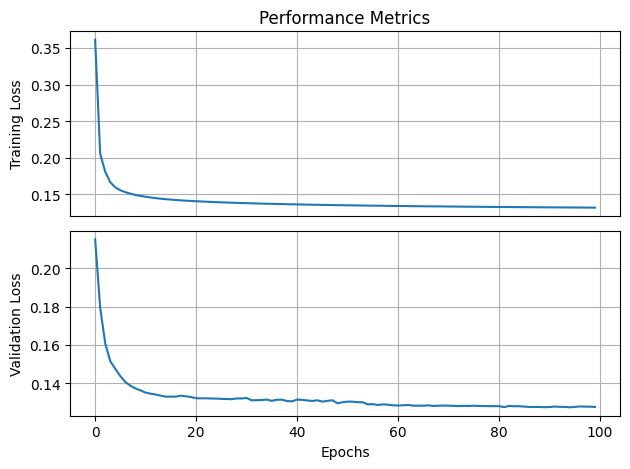

In [17]:
# Plot of train and loss functions

plt.figure()

plt.subplot(2,1,1)
plt.plot(loss_train_hist)
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
plt.ylabel("Training Loss")
plt.title("Performance Metrics")
plt.grid()

plt.subplot(2,1,2)
plt.plot(loss_val_hist)
plt.xlabel("Epochs")
plt.ylabel("Validation Loss")
plt.grid()

plt.tight_layout()

plt.show()

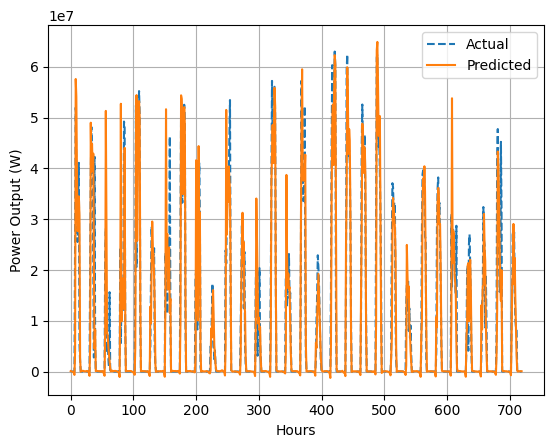

In [18]:
# Run on test data

lstm_net.eval()
with torch.no_grad():
  predictions = lstm_net(test_inputs)

#predictions = predictions.cpu()
#predictions = output_scaler.inverse_transform(predictions)

fix, ax = plt.subplots()

ax.plot(output_scaler.inverse_transform(test_outputs.cpu()[0:720]), "--", label="Actual")
ax.plot(output_scaler.inverse_transform(predictions.cpu()[0:720]), label="Predicted")

ax.set_xlabel("Hours")
ax.set_ylabel("Power Output (W)")

ax.legend()
ax.grid()

plt.show()

## 3. Spiking Neural Network (SNN)

The SNN is now trained. We use 3-layers of leaky integrate-and-fire neurons with `size=128`. Notably, the last layer has the reset mechanism disabled to give us a single value output of membrane potential rather than the typical output spikes. The input features are passed directly into the network and repeated `TIMESTEP=20` times. The training of the SNN takes significantly more time than the LSTM network (~3hr with a Nvidia 1080Ti)

In [19]:
#
# Define model
#
class SNN(torch.nn.Module):
    """Simple spiking neural network in snntorch."""

    def __init__(self, timesteps, in_features, hidden):
        super().__init__()

        self.timesteps = timesteps # number of time steps to simulate the network
        self.hidden = hidden # number of hidden neurons
        spike_grad = surrogate.fast_sigmoid() # surrogate gradient function

        # randomly initialize decay rate and threshold for layer 1
        beta_in = torch.rand(self.hidden)
        thr_in = torch.rand(self.hidden)

        # layer 1
        self.fc_in = torch.nn.Linear(in_features=in_features, out_features=self.hidden)
        self.lif_in = snn.Leaky(beta=beta_in, threshold=thr_in, learn_beta=True, spike_grad=spike_grad)

        # randomly initialize decay rate and threshold for layer 2
        beta_hidden = torch.rand(self.hidden)
        thr_hidden = torch.rand(self.hidden)

        # layer 2
        self.fc_hidden = torch.nn.Linear(in_features=self.hidden, out_features=self.hidden)
        self.lif_hidden = snn.Leaky(beta=beta_hidden, threshold=thr_hidden, learn_beta=True, spike_grad=spike_grad)

        # randomly initialize decay rate for output neuron
        beta_out = torch.rand(1)

        # layer 3: leaky integrator neuron. Note the reset mechanism is disabled and we will disregard output spikes.
        self.fc_out = torch.nn.Linear(in_features=self.hidden, out_features=1)
        self.li_out = snn.Leaky(beta=beta_out, threshold=1.0, learn_beta=True, spike_grad=spike_grad, reset_mechanism="none")

    def forward(self, x):
        """Forward pass for several time steps."""

        # Initalize membrane potential
        mem_1 = self.lif_in.init_leaky()
        mem_2 = self.lif_hidden.init_leaky()
        mem_3 = self.li_out.init_leaky()

        # Empty lists to record outputs
        mem_3_rec = []

        # Loop over
        for step in range(self.timesteps):
            cur_in = self.fc_in(x)
            spk_in, mem_1 = self.lif_in(cur_in, mem_1)

            cur_hidden = self.fc_hidden(spk_in)
            spk_hidden, mem_2 = self.lif_hidden(cur_hidden, mem_2)

            cur_out = self.fc_out(spk_hidden)
            _, mem_3 = self.li_out(cur_out, mem_3)

            mem_3_rec.append(mem_3)

        return torch.stack(mem_3_rec)

# Parameters
TIMESTEPS = 20
HIDDEN_LAYERS = 128

snn_net = SNN(
  timesteps=TIMESTEPS,
  hidden=HIDDEN_LAYERS,
  in_features=len(train_inputs[0])
  )
snn_net = snn_net.to(device)


#
# Output without any training
#

# run a single forward-pass to see what output is
with torch.no_grad():
  for inputs, outputs in train_loader:
    mem = snn_net(inputs)

# record outputs for later plotting
sample_outputs = outputs
sample_mem = mem


#
# Training loop
#

# hyperparameters
EPOCHS = 100
LEARNING_RATE = 1e-3

# optimizer
optimizer = torch.optim.Adam(params=snn_net.parameters(), lr=1e-3)
# loss function for membrane potential
loss_function = torch.nn.MSELoss()

# list to store loss at each timestep
loss_train_hist = []
loss_val_hist = []

# training loop
for epoch in tqdm(range(EPOCHS)):
  loss_train_epoch = []

  snn_net.train()
  for inputs, outputs in train_loader:
    # forward pass
    mem = snn_net(inputs)
    # calculate loss from membrane potential at last timestep
    loss_val = loss_function(mem[-1,:,:], outputs)
    # zero out gradients
    optimizer.zero_grad()
    # calculate gradients
    loss_val.backward()
    # update weights
    optimizer.step()

    # store loss
    loss_train_epoch.append(loss_val.item())

  # calculate average loss p/epoch
  avg_loss_epoch_train = sum(loss_train_epoch) / len(loss_train_epoch)
  loss_train_hist.append(avg_loss_epoch_train)


  loss_val_epoch = []

  snn_net.eval()
  for inputs, outputs in val_loader:
    mem = snn_net(inputs)
    loss_val = loss_function(mem[-1,:,:], outputs)
    loss_val_epoch.append(loss_val.item())

  avg_loss_epoch_val = sum(loss_val_epoch) / len(loss_val_epoch)
  loss_val_hist.append(avg_loss_epoch_val)

  print(f"Epoch: {epoch+1}/{EPOCHS}, Train Loss: {avg_loss_epoch_train}, Val Loss: {avg_loss_epoch_val}")

  1%| | 1/100 [00:17<28:29, 17.27s/it

Epoch: 1/100, Train Loss: 0.15468561775455056, Val Loss: 0.11613910354399046


  2%| | 2/100 [00:34<28:09, 17.24s/it

Epoch: 2/100, Train Loss: 0.12492071784411868, Val Loss: 0.1025405458754814


  3%| | 3/100 [00:51<27:56, 17.29s/it

Epoch: 3/100, Train Loss: 0.11942720404234991, Val Loss: 0.103394088014716


  4%| | 4/100 [01:09<27:39, 17.29s/it

Epoch: 4/100, Train Loss: 0.11655054924792725, Val Loss: 0.09896134209559589


  5%| | 5/100 [01:26<27:22, 17.29s/it

Epoch: 5/100, Train Loss: 0.11500423728109903, Val Loss: 0.09461162067171125


  6%| | 6/100 [01:43<27:06, 17.31s/it

Epoch: 6/100, Train Loss: 0.11365158527783335, Val Loss: 0.09875615709461272


  7%| | 7/100 [02:01<26:49, 17.31s/it

Epoch: 7/100, Train Loss: 0.11257048790645041, Val Loss: 0.09299216178993953


  8%| | 8/100 [02:18<26:29, 17.28s/it

Epoch: 8/100, Train Loss: 0.11213382172555617, Val Loss: 0.09460654372318847


  9%| | 9/100 [02:35<26:12, 17.28s/it

Epoch: 9/100, Train Loss: 0.1119116897248242, Val Loss: 0.09434915040466996


 10%| | 10/100 [02:52<25:54, 17.27s/i

Epoch: 10/100, Train Loss: 0.11134606413628277, Val Loss: 0.09613929165634097


 11%| | 11/100 [03:10<25:36, 17.26s/i

Epoch: 11/100, Train Loss: 0.11072389235077894, Val Loss: 0.09293884037398413


 12%| | 12/100 [03:27<25:20, 17.28s/i

Epoch: 12/100, Train Loss: 0.10990056796169512, Val Loss: 0.09252983933604765


 13%|▏| 13/100 [03:44<25:01, 17.26s/i

Epoch: 13/100, Train Loss: 0.10978578888071217, Val Loss: 0.09186963965643014


 14%|▏| 14/100 [04:02<24:50, 17.34s/i

Epoch: 14/100, Train Loss: 0.10880197540231763, Val Loss: 0.09130207095753218


 15%|▏| 15/100 [04:19<24:29, 17.29s/i

Epoch: 15/100, Train Loss: 0.1088665409498427, Val Loss: 0.09118828217147804


 16%|▏| 16/100 [04:36<24:10, 17.26s/i

Epoch: 16/100, Train Loss: 0.10877230139576817, Val Loss: 0.09104962852691896


 17%|▏| 17/100 [04:53<23:53, 17.27s/i

Epoch: 17/100, Train Loss: 0.1081621045057479, Val Loss: 0.09242777301563469


 18%|▏| 18/100 [05:10<23:33, 17.23s/i

Epoch: 18/100, Train Loss: 0.1080976349860855, Val Loss: 0.09032134835791515


 19%|▏| 19/100 [05:28<23:16, 17.24s/i

Epoch: 19/100, Train Loss: 0.10829644929490065, Val Loss: 0.09213258436361908


 20%|▏| 20/100 [05:45<23:04, 17.30s/i

Epoch: 20/100, Train Loss: 0.10800463207274437, Val Loss: 0.09045757968971109


 21%|▏| 21/100 [06:02<22:46, 17.30s/i

Epoch: 21/100, Train Loss: 0.10775207588193964, Val Loss: 0.09339839438373437


 22%|▏| 22/100 [06:20<22:32, 17.34s/i

Epoch: 22/100, Train Loss: 0.10750810253842134, Val Loss: 0.09863149004866231


 23%|▏| 23/100 [06:37<22:13, 17.32s/i

Epoch: 23/100, Train Loss: 0.10767756169895773, Val Loss: 0.08956248857859583


 24%|▏| 24/100 [06:54<21:56, 17.32s/i

Epoch: 24/100, Train Loss: 0.1077156628318318, Val Loss: 0.09124453057015895


 25%|▎| 25/100 [07:12<21:36, 17.29s/i

Epoch: 25/100, Train Loss: 0.10692649199935654, Val Loss: 0.08860509073529697


 26%|▎| 26/100 [07:29<21:20, 17.30s/i

Epoch: 26/100, Train Loss: 0.10670531227840238, Val Loss: 0.09175139823241434


 27%|▎| 27/100 [07:46<21:02, 17.29s/i

Epoch: 27/100, Train Loss: 0.10755658815338459, Val Loss: 0.08917687762314912


 28%|▎| 28/100 [08:03<20:42, 17.26s/i

Epoch: 28/100, Train Loss: 0.10660569765498717, Val Loss: 0.09198110785762795


 29%|▎| 29/100 [08:21<20:25, 17.26s/i

Epoch: 29/100, Train Loss: 0.10673960575931726, Val Loss: 0.09292810944626566


 30%|▎| 30/100 [08:38<20:08, 17.26s/i

Epoch: 30/100, Train Loss: 0.1067997327174345, Val Loss: 0.09017791707435104


 31%|▎| 31/100 [08:55<19:53, 17.30s/i

Epoch: 31/100, Train Loss: 0.10629776930032493, Val Loss: 0.09325913484131948


 32%|▎| 32/100 [09:13<19:35, 17.29s/i

Epoch: 32/100, Train Loss: 0.1073675106770729, Val Loss: 0.09035284595457135


 33%|▎| 33/100 [09:30<19:19, 17.30s/i

Epoch: 33/100, Train Loss: 0.10663769206512702, Val Loss: 0.08961241862919854


 34%|▎| 34/100 [09:47<19:02, 17.31s/i

Epoch: 34/100, Train Loss: 0.10711198210478101, Val Loss: 0.09084368566600759


 35%|▎| 35/100 [10:04<18:42, 17.28s/i

Epoch: 35/100, Train Loss: 0.10644772575964054, Val Loss: 0.09150345130731947


 36%|▎| 36/100 [10:22<18:24, 17.26s/i

Epoch: 36/100, Train Loss: 0.10677206545715225, Val Loss: 0.08957265058654498


 37%|▎| 37/100 [10:39<18:05, 17.22s/i

Epoch: 37/100, Train Loss: 0.10596931082915226, Val Loss: 0.08818594471276661


 38%|▍| 38/100 [10:56<17:46, 17.21s/i

Epoch: 38/100, Train Loss: 0.10605501691729988, Val Loss: 0.08860278359354763


 39%|▍| 39/100 [11:13<17:28, 17.19s/i

Epoch: 39/100, Train Loss: 0.106339591857233, Val Loss: 0.0881961109651039


 40%|▍| 40/100 [11:30<17:09, 17.16s/i

Epoch: 40/100, Train Loss: 0.105875604408134, Val Loss: 0.08900244197365446


 41%|▍| 41/100 [11:47<16:50, 17.12s/i

Epoch: 41/100, Train Loss: 0.10606969458893044, Val Loss: 0.08908627431870239


 42%|▍| 42/100 [12:04<16:33, 17.13s/i

Epoch: 42/100, Train Loss: 0.10607605827929767, Val Loss: 0.0893149912113049


 43%|▍| 43/100 [12:21<16:15, 17.11s/i

Epoch: 43/100, Train Loss: 0.10661646167462752, Val Loss: 0.08978163585692767


 44%|▍| 44/100 [12:39<15:58, 17.12s/i

Epoch: 44/100, Train Loss: 0.10680302680559355, Val Loss: 0.08985260286803556


 45%|▍| 45/100 [12:56<15:41, 17.13s/i

Epoch: 45/100, Train Loss: 0.10629023688879358, Val Loss: 0.08836102705128247


 46%|▍| 46/100 [13:13<15:24, 17.13s/i

Epoch: 46/100, Train Loss: 0.10573826779220168, Val Loss: 0.08879552214009473


 47%|▍| 47/100 [13:30<15:07, 17.12s/i

Epoch: 47/100, Train Loss: 0.10587634417913072, Val Loss: 0.08912406845751111


 48%|▍| 48/100 [13:47<14:51, 17.14s/i

Epoch: 48/100, Train Loss: 0.1058788384808457, Val Loss: 0.08769595641719147


 49%|▍| 49/100 [14:04<14:34, 17.15s/i

Epoch: 49/100, Train Loss: 0.10564140514725794, Val Loss: 0.0876186784780508


 50%|▌| 50/100 [14:21<14:17, 17.15s/i

Epoch: 50/100, Train Loss: 0.10561854940154441, Val Loss: 0.08873523422135193


 51%|▌| 51/100 [14:39<14:00, 17.16s/i

Epoch: 51/100, Train Loss: 0.10635711016052628, Val Loss: 0.09098298081242648


 52%|▌| 52/100 [14:56<13:43, 17.15s/i

Epoch: 52/100, Train Loss: 0.10543418650825818, Val Loss: 0.08813574584964358


 53%|▌| 53/100 [15:13<13:25, 17.15s/i

Epoch: 53/100, Train Loss: 0.10563350212271219, Val Loss: 0.08887857520479525


 54%|▌| 54/100 [15:30<13:08, 17.15s/i

Epoch: 54/100, Train Loss: 0.10537942048549209, Val Loss: 0.08860191667727271


 55%|▌| 55/100 [15:47<12:52, 17.16s/i

Epoch: 55/100, Train Loss: 0.10589903242945603, Val Loss: 0.0885333379264921


 56%|▌| 56/100 [16:05<12:36, 17.19s/i

Epoch: 56/100, Train Loss: 0.10565282692112131, Val Loss: 0.09033892369737513


 57%|▌| 57/100 [16:22<12:17, 17.16s/i

Epoch: 57/100, Train Loss: 0.10539348298836856, Val Loss: 0.08699828890900387


 58%|▌| 58/100 [16:39<11:59, 17.13s/i

Epoch: 58/100, Train Loss: 0.10525883813792644, Val Loss: 0.09171090073135423


 59%|▌| 59/100 [16:56<11:43, 17.15s/i

Epoch: 59/100, Train Loss: 0.10576089400772566, Val Loss: 0.09071375527724501


 60%|▌| 60/100 [17:13<11:26, 17.15s/i

Epoch: 60/100, Train Loss: 0.1061408456712621, Val Loss: 0.08960656678212471


 61%|▌| 61/100 [17:30<11:08, 17.13s/i

Epoch: 61/100, Train Loss: 0.10548042968472628, Val Loss: 0.09112821875109536


 62%|▌| 62/100 [17:47<10:51, 17.14s/i

Epoch: 62/100, Train Loss: 0.10615130383585107, Val Loss: 0.08959422904814852


 63%|▋| 63/100 [18:05<10:35, 17.16s/i

Epoch: 63/100, Train Loss: 0.10590086199989601, Val Loss: 0.09269948212475684


 64%|▋| 64/100 [18:22<10:17, 17.15s/i

Epoch: 64/100, Train Loss: 0.10597496893507807, Val Loss: 0.08901765696765458


 65%|▋| 65/100 [18:39<09:59, 17.13s/i

Epoch: 65/100, Train Loss: 0.106057050816298, Val Loss: 0.09144463716456513


 66%|▋| 66/100 [18:56<09:42, 17.13s/i

Epoch: 66/100, Train Loss: 0.10587684119685838, Val Loss: 0.08884557086562157


 67%|▋| 67/100 [19:13<09:24, 17.11s/i

Epoch: 67/100, Train Loss: 0.10589562821304042, Val Loss: 0.0894596177825063


 68%|▋| 68/100 [19:30<09:07, 17.09s/i

Epoch: 68/100, Train Loss: 0.10556914749891247, Val Loss: 0.08787047543532414


 69%|▋| 69/100 [19:47<08:50, 17.10s/i

Epoch: 69/100, Train Loss: 0.10607975827249354, Val Loss: 0.09105757239931186


 70%|▋| 70/100 [20:04<08:33, 17.11s/i

Epoch: 70/100, Train Loss: 0.10615384482595747, Val Loss: 0.08816991288779823


 71%|▋| 71/100 [20:21<08:16, 17.12s/i

Epoch: 71/100, Train Loss: 0.10640450612977828, Val Loss: 0.09033989241026098


 72%|▋| 72/100 [20:38<07:58, 17.09s/i

Epoch: 72/100, Train Loss: 0.10598652441209803, Val Loss: 0.08809657433818353


 73%|▋| 73/100 [20:56<07:41, 17.10s/i

Epoch: 73/100, Train Loss: 0.10559613188371471, Val Loss: 0.08881434038296708


 74%|▋| 74/100 [21:13<07:24, 17.11s/i

Epoch: 74/100, Train Loss: 0.1056014771915581, Val Loss: 0.08938464648701007


 75%|▊| 75/100 [21:30<07:08, 17.12s/i

Epoch: 75/100, Train Loss: 0.10593792142040313, Val Loss: 0.08873893101852326


 76%|▊| 76/100 [21:47<06:51, 17.14s/i

Epoch: 76/100, Train Loss: 0.10546916201051545, Val Loss: 0.08867268245590881


 77%|▊| 77/100 [22:04<06:33, 17.11s/i

Epoch: 77/100, Train Loss: 0.1059246070334288, Val Loss: 0.08921070381250905


 78%|▊| 78/100 [22:21<06:16, 17.12s/i

Epoch: 78/100, Train Loss: 0.10584951879278029, Val Loss: 0.08874918021200622


 79%|▊| 79/100 [22:38<05:59, 17.14s/i

Epoch: 79/100, Train Loss: 0.10652826804897353, Val Loss: 0.08969016351401195


 80%|▊| 80/100 [22:56<05:43, 17.18s/i

Epoch: 80/100, Train Loss: 0.1068234000187027, Val Loss: 0.09139356441551545


 81%|▊| 81/100 [23:13<05:26, 17.20s/i

Epoch: 81/100, Train Loss: 0.10707533217617843, Val Loss: 0.09006041544871252


 82%|▊| 82/100 [23:30<05:09, 17.20s/i

Epoch: 82/100, Train Loss: 0.10619882610137468, Val Loss: 0.0886040501120943


 83%|▊| 83/100 [23:47<04:52, 17.19s/i

Epoch: 83/100, Train Loss: 0.10541115270812727, Val Loss: 0.0904538811291339


 84%|▊| 84/100 [24:05<04:36, 17.27s/i

Epoch: 84/100, Train Loss: 0.10596446048289741, Val Loss: 0.08832309928295187


 85%|▊| 85/100 [24:22<04:20, 17.37s/i

Epoch: 85/100, Train Loss: 0.10604901066077575, Val Loss: 0.08879989372627413


 86%|▊| 86/100 [24:40<04:06, 17.63s/i

Epoch: 86/100, Train Loss: 0.10576268467609877, Val Loss: 0.08811494374846215


 87%|▊| 87/100 [25:00<03:55, 18.12s/i

Epoch: 87/100, Train Loss: 0.10622986692203779, Val Loss: 0.09047087172015769


 88%|▉| 88/100 [25:21<03:48, 19.03s/i

Epoch: 88/100, Train Loss: 0.1059570030358165, Val Loss: 0.08807708833320829


 89%|▉| 89/100 [25:39<03:27, 18.89s/i

Epoch: 89/100, Train Loss: 0.10610589978378691, Val Loss: 0.08780255035848403


 90%|▉| 90/100 [25:57<03:03, 18.40s/i

Epoch: 90/100, Train Loss: 0.10619809513669205, Val Loss: 0.0875996488764821


 91%|▉| 91/100 [26:14<02:42, 18.03s/i

Epoch: 91/100, Train Loss: 0.10645194376699763, Val Loss: 0.08889829379994972


 92%|▉| 92/100 [26:31<02:22, 17.77s/i

Epoch: 92/100, Train Loss: 0.10547861261931184, Val Loss: 0.08718399845491179


 93%|▉| 93/100 [26:48<02:03, 17.60s/i

Epoch: 93/100, Train Loss: 0.10584019898356165, Val Loss: 0.08895149022020156


 94%|▉| 94/100 [27:05<01:44, 17.49s/i

Epoch: 94/100, Train Loss: 0.10632056782753568, Val Loss: 0.08813618472013927


 95%|▉| 95/100 [27:23<01:26, 17.38s/i

Epoch: 95/100, Train Loss: 0.10639312575554229, Val Loss: 0.08935256230599078


 96%|▉| 96/100 [27:40<01:09, 17.31s/i

Epoch: 96/100, Train Loss: 0.10619307358528075, Val Loss: 0.08835535587697121


 97%|▉| 97/100 [27:57<00:51, 17.28s/i

Epoch: 97/100, Train Loss: 0.1061905410508604, Val Loss: 0.08853852844674934


 98%|▉| 98/100 [28:14<00:34, 17.26s/i

Epoch: 98/100, Train Loss: 0.10646389290354466, Val Loss: 0.09268887936839926


 99%|▉| 99/100 [28:31<00:17, 17.20s/i

Epoch: 99/100, Train Loss: 0.10641397884345218, Val Loss: 0.08968876104527077


100%|█| 100/100 [28:49<00:00, 17.29s/

Epoch: 100/100, Train Loss: 0.10754300387678285, Val Loss: 0.08880125383892265


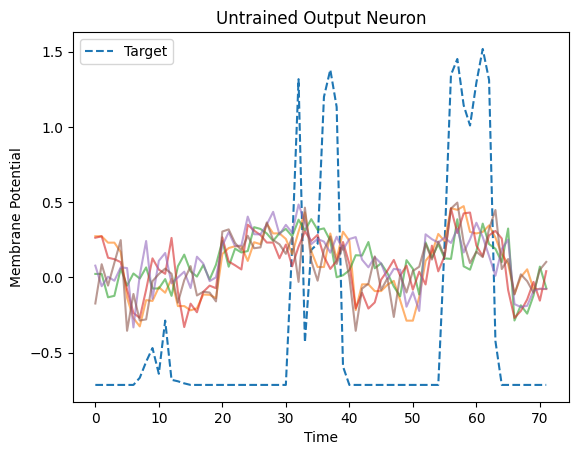

In [20]:
# Plot of network before training

fig, ax = plt.subplots()
# plot expected output
ax.plot(sample_outputs.squeeze(1).cpu(), '--', label="Target")
# plot first 5 membrane potential outputs
for idx in range(0, min(TIMESTEPS, 5)):
  ax.plot(sample_mem[idx,:,0].cpu(), alpha=0.6)

ax.set_title("Untrained Output Neuron")
ax.set_xlabel("Time")
ax.set_ylabel("Membrane Potential")
ax.legend(loc='best')
plt.show()

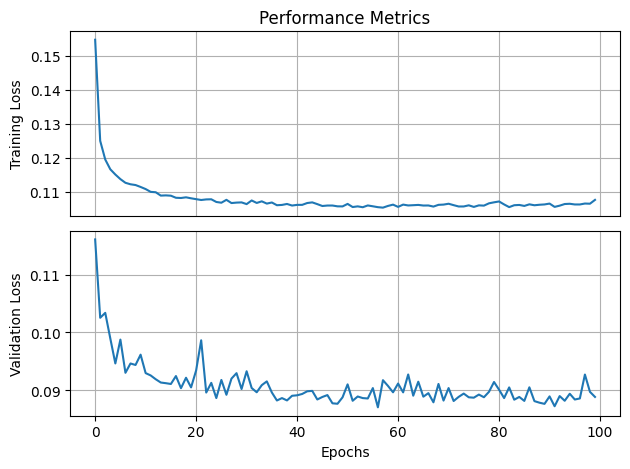

In [21]:
# Plot of train and loss functions

plt.figure()

plt.subplot(2,1,1)
plt.plot(loss_train_hist)
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
plt.ylabel("Training Loss")
plt.title("Performance Metrics")
plt.grid()

plt.subplot(2,1,2)
plt.plot(loss_val_hist)
plt.xlabel("Epochs")
plt.ylabel("Validation Loss")
plt.grid()

plt.tight_layout()

plt.show()


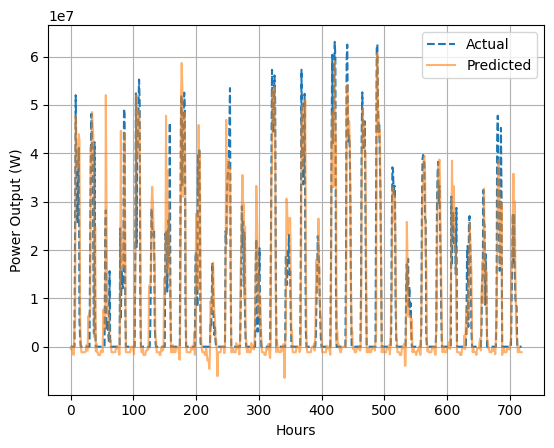

In [22]:
# Run on test data

snn_net.eval()
with torch.no_grad():
  predictions = snn_net(test_inputs)

#predictions = predictions.cpu()
#predictions = output_scaler.inverse_transform(predictions)

fix, ax = plt.subplots()

ax.plot(output_scaler.inverse_transform(test_outputs.cpu()[0:720]), "--", label="Actual")
ax.plot(output_scaler.inverse_transform(predictions.cpu()[0,0:720,:]), label="Predicted", alpha=0.6)

ax.set_xlabel("Hours")
ax.set_ylabel("Power Output (W)")

ax.legend()
ax.grid()

plt.show()

## Comparison Between LSTM and SNN

Below shows the loss function (mean absolute error) for the test dataset after being transformed back into the original units. The SNN had approximately double the error as the LSTM when trained under similar conditions. The plot of SNN output shows it has issues with extreme points of the data when it was close to zero or at peak output. There were less over estimations compared to the LSTM.

LSTM MAE: 3245429.3637870643
SNN MAE: 4856190.275832422


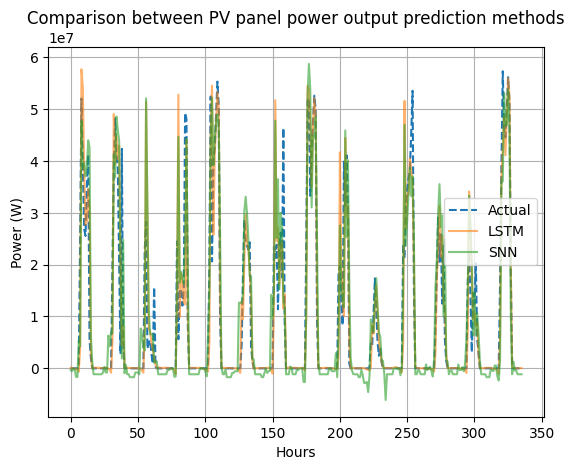

In [23]:
TW = 24 * 14

lstm_net.eval()
snn_net.eval()
with torch.no_grad():
  lstm_predictions = lstm_net(test_inputs)
  snn_predictions = snn_net(test_inputs)

loss_fn = nn.L1Loss()

lstm_predictions = output_scaler.inverse_transform(lstm_predictions.cpu())
snn_predictions = output_scaler.inverse_transform(snn_predictions.cpu()[0,:,:])
actual_output = output_scaler.inverse_transform(test_outputs.cpu())

mae_lstm = np.mean(np.abs(actual_output - lstm_predictions))
mae_snn = np.mean(np.abs(actual_output - snn_predictions))

print(f"LSTM MAE: {mae_lstm}")
print(f"SNN MAE: {mae_snn}")

plt.figure()

plt.plot(actual_output[0:TW], "--", label="Actual")
plt.plot(lstm_predictions[0:TW], alpha=0.6, label="LSTM")
plt.plot(snn_predictions[0:TW], alpha=0.6, label="SNN")

plt.xlabel("Hours")
plt.ylabel("Power (W)")
plt.title("Comparison between PV panel power output prediction methods")

plt.legend()
plt.grid()

plt.show()